## Implementation

In [1]:
from IOHMM import IOHMM_model
import numpy as np, pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/Financial-Data/stocks/TSLA.csv")
data.head()
data = data.dropna()

input = torch.tensor(np.array(data[['Open']]), dtype=torch.float32)
output = torch.tensor(np.array(data['Close']), dtype=torch.float32)

# Example 1

## Set up a simple model manully

In [3]:
xx=np.arange(0,100,0.1)
y= np.sin(xx)
inputs=torch.tensor(xx, dtype=torch.float32)
outputs=torch.tensor(y, dtype=torch.float32)
inputs=inputs.reshape(-1,1)

In [4]:
transition_matrix = torch.tensor([[[1.,0.],[1.,0.]],[[1.,0.],[1.,0.]]])
emission_matrix = torch.tensor([[-0.1,0.1],[0.1,0.1]])

IOHMM = IOHMM_model(num_states=2, inputs=input[:10], outputs=output[:10], max_iter=100, tol=1e-4, transition_matrix=transition_matrix, emission_matrix=emission_matrix)
print(f"initial pi {IOHMM.initial_pi}")
print(IOHMM.transition_matrix)
print(IOHMM.emission_matrix)
print(IOHMM.log_sd)

initial pi Parameter containing:
tensor([-0.6931, -0.6931], requires_grad=True)
Parameter containing:
tensor([[[1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.]]], requires_grad=True)
Parameter containing:
tensor([[-0.1000,  0.1000],
        [ 0.1000,  0.1000]], requires_grad=True)
Parameter containing:
tensor([1.6094, 1.6094], requires_grad=True)


In [5]:
print(IOHMM._forward())
# torch.sum(IOHMM._forward(), dim=1)

tensor([[-0.6990, -0.6873],
        [-0.6988, -0.6875],
        [-0.6983, -0.6880],
        [-0.6977, -0.6887],
        [-0.6969, -0.6894],
        [-0.6969, -0.6894],
        [-0.6974, -0.6889],
        [-0.6973, -0.6890],
        [-0.6972, -0.6891],
        [-0.6975, -0.6888]])


In [6]:
print(IOHMM._backward())
# torch.sum(IOHMM._backward(), dim=1)

tensor([[-0.6990, -0.6873],
        [-0.6988, -0.6875],
        [-0.6983, -0.6880],
        [-0.6977, -0.6887],
        [-0.6969, -0.6894],
        [-0.6969, -0.6894],
        [-0.6974, -0.6889],
        [-0.6973, -0.6890],
        [-0.6972, -0.6891],
        [-0.6975, -0.6888]])


In [7]:
print(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()))
# torch.sum(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()), dim=1)

tensor([[-0.7049, -0.6815],
        [-0.7045, -0.6819],
        [-0.7036, -0.6828],
        [-0.7022, -0.6842],
        [-0.7007, -0.6857],
        [-0.7007, -0.6856],
        [-0.7016, -0.6847],
        [-0.7015, -0.6848],
        [-0.7013, -0.6850],
        [-0.7019, -0.6844]])


In [8]:
print(IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()))
# torch.sum(IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()), axis=1)

tensor([[[-0.6990, -0.6990],
         [-0.6873, -0.6873]],

        [[-0.6988, -0.6988],
         [-0.6875, -0.6875]],

        [[-0.6983, -0.6983],
         [-0.6880, -0.6880]],

        [[-0.6977, -0.6977],
         [-0.6887, -0.6887]],

        [[-0.6969, -0.6969],
         [-0.6894, -0.6894]],

        [[-0.6969, -0.6969],
         [-0.6894, -0.6894]],

        [[-0.6974, -0.6974],
         [-0.6889, -0.6889]],

        [[-0.6973, -0.6973],
         [-0.6890, -0.6890]],

        [[-0.6972, -0.6972],
         [-0.6891, -0.6891]],

        [[-0.6975, -0.6975],
         [-0.6888, -0.6888]]])


In [9]:
IOHMM._baum_welch()

Iteration 1, likelihood: -inf
Iteration 2, likelihood: -35.67226791381836
Iteration 3, likelihood: -31.692222595214844
Iteration 4, likelihood: -27.602073669433594
Iteration 5, likelihood: -22.59109878540039
Iteration 6, likelihood: -17.052021026611328
Iteration 7, likelihood: -109.5283203125
Iteration 8, likelihood: -11.663751602172852
Iteration 9, likelihood: -74.66219329833984
Iteration 10, likelihood: -121.4227066040039
Iteration 11, likelihood: -87.98294067382812
Iteration 12, likelihood: -78.2755355834961
Iteration 13, likelihood: -70.74098205566406
Iteration 14, likelihood: -69.60716247558594
Iteration 15, likelihood: -69.6021499633789
Iteration 16, likelihood: -69.327392578125
Iteration 17, likelihood: -69.2852783203125
Iteration 18, likelihood: -69.07714080810547
Iteration 19, likelihood: -69.01698303222656
Iteration 20, likelihood: -68.83958435058594
Iteration 21, likelihood: -68.76874542236328
Iteration 22, likelihood: -68.60884094238281
Iteration 23, likelihood: -68.5309753

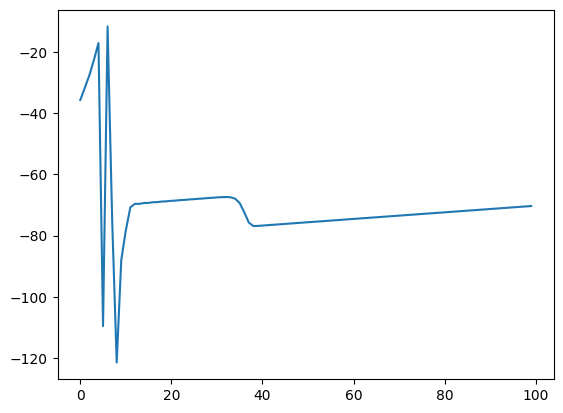

In [10]:
plt.plot(IOHMM.history)

## See the training results

In [11]:
print("Initial pi")
print(IOHMM.initial_pi) # to normalize
print("Transition matrix")
print(IOHMM.transition_matrix)
print("Emission matrix")
print(IOHMM.emission_matrix)
print("Sd")
print(IOHMM.log_sd)

Initial pi
Parameter containing:
tensor([ 8.8479, -0.2342], requires_grad=True)
Transition matrix
Parameter containing:
tensor([[[ 6.0175e-01, -5.3090e-01],
         [ 1.3983e+00,  5.3090e-01]],

        [[ 1.0001e+00,  1.4070e-04],
         [ 9.9987e-01, -1.4069e-04]]], requires_grad=True)
Emission matrix
Parameter containing:
tensor([[21.4870, 29.2242],
        [-0.6904, -0.8381]], requires_grad=True)
Sd
Parameter containing:
tensor([ 4.1273, -0.8605], requires_grad=True)


## Viterbi

In [12]:
#call the viterbi algorithm
IOHMM.viterbi()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Predict

In [13]:
# predict the next output given the next input
IOHMM.predict(input[11])


tensor(5.4362, grad_fn=<SumBackward0>)

In [14]:
output[11]

tensor(1.3260)